In [1]:
import os, sys
import random
import argparse
from pathlib import Path
import logging
from torch import cuda
from tqdm import tqdm 
import pickle

from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# from flair.data import Sentence
# from flair.models import SequenceTagger

# import spacy

# from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup
# from transformers_interpret import SequenceClassificationExplainer
from transformers import BertTokenizer, BertTokenizerFast, BertForSequenceClassification


# %% Loading custom libraries 
sys.path.append('../metrics/')
from performance import f1_score_func, accuracy_per_class

# Loading the custom library
sys.path.append('../process/')
from load_data import FetchData, ContextualizedData
from utils import merge_and_create_dataframe, train_model, evaluate_model, clean_and_merge_data_for_tokenization, add_tokens_to_vocabulary

# from captum.attr import visualization as viz
# from captum.attr import LayerConductance, LayerIntegratedGradients

# from scipy.special import softmax
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# data='alpha-dreams' ,
args = dict(ads_count=20,
 batch_size=64,
 cuda=False,
 data='alpha-dreams', 
 data_dir='../data',
 delta=0.01,
 dropout=0.65,
 early_stopping=True,
 eval_per_steps=2000,
 hidden_states=512,
 load_model='epoch_38.model',
 lr=4e-05,
 max_seq_len=512,
 mode='train',
 model='bert',
 n_splits=5,
 nb_epochs=10,
 patience=3,
 preprocess_flag=False,
 save_dir='../models/merged',
 seed=1111,
 setting='high',
 split_ratio=0.25,
 version='full')

In [3]:
# %% Loading the datasets
alpha_df = pd.read_csv(os.path.join(args['data_dir'], "preprocessed_alpha.csv"), error_bad_lines=False, 
                            lineterminator='\n', usecols=['marketplace', 'title', 'vendor', 'prediction', 'ships_to', 'ships_from', 'description']).drop_duplicates()
dreams_df = pd.read_csv(os.path.join(args['data_dir'], "preprocessed_dreams.csv"), error_bad_lines=False, 
                            lineterminator='\n', usecols=['marketplace', 'title', 'vendor', 'prediction', 'ships_to', 'ships_from', 'description']).drop_duplicates()
silk_df = pd.read_csv(os.path.join(args['data_dir'], "preprocessed_silk.csv"), error_bad_lines=False, 
                            lineterminator='\n', usecols=['marketplace', 'title', 'vendor', 'prediction', 'ships_to', 'ships_from', 'description']).drop_duplicates()
data_df = {"alpha":alpha_df, "dreams":dreams_df, "silk":silk_df}

In [4]:
[(train_alpha_dreams, train_dreams_silk, train_alpha_silk, train_alpha_dreams_silk, train_alpha, train_dreams, train_silk), (test_alpha_dreams, test_dreams_silk, test_alpha_silk, test_alpha_dreams_silk, test_alpha, test_dreams, test_silk)] = FetchData(data_df, args["version"], args["data"],  args["split_ratio"], args["preprocess_flag"], args["setting"], args["ads_count"],  args["seed"]).split_data()

Cleaning the data ...
Training and Test data size for Alphabay market : (75327, 7) (25109, 7)
Training and Test data size for Dreams market : (70198, 7) (23400, 7)
Training and Test data size for Silk-Road market : (89544, 7) (29848, 7)
Splitting combined data ...


In [5]:
[(train_valhalla_traderoute, train_traderoute_berlusconi, train_valhalla_berlusconi, train_valhalla_traderoute_berlusconi, train_valhalla, train_traderoute, train_berlusconi),
                        (test_valhalla_traderoute, test_traderoute_berlusconi, test_valhalla_berlusconi, test_valhalla_traderoute_berlusconi, test_valhalla, test_traderoute, test_berlusconi)] = FetchData(data_df, args["version"], args["data"],  args["split_ratio"], args["preprocess_flag"], args["setting"], args["ads_count"],  args["seed"]).split_data()

Cleaning the data ...
Training and Test data size for Valhalla market : (1631, 7) (544, 7)
Training and Test data size for Traderoute market : (14964, 7) (4989, 7)
Training and Test data size for Berlusconi market : (1077, 7) (360, 7)
Splitting combined data ...


In [5]:
data = pd.concat([train_dreams, test_dreams, train_alpha, test_alpha, train_silk, test_silk])
all_vendors = list(data['vendor'].unique())
vendor_to_idx_dict = {vendor_name:index for index, vendor_name in enumerate(all_vendors)}
# data['vendor'] = data['vendor'].replace(vendor_to_idx_dict, regex=True)
# sample_df = merge_and_create_dataframe(sample_df)

In [78]:
data = merge_and_create_dataframe(data)

In [6]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                            num_labels=len(vendor_to_idx_dict),
                                            output_attentions=False,
                                            output_hidden_states=True).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
# load model
model.load_state_dict(torch.load(os.path.join(args['save_dir'], args['model'], args['load_model'])))
model.eval()
model.zero_grad()

In [13]:
model.classifier

Linear(in_features=768, out_features=3896, bias=True)

In [36]:
# model.to(device)

# Helper class to collect the activations

In [19]:
def extract_layer_representations(model, dataloader_, vendor_to_idx_dict, device, mode='all'):    
    # Initializing the layers with zero activation with (layer, mean embedding)
    layer_representations = torch.zeros(13,768)
    concat_hidden_repr = []
    vendor_dict = {}
    model.eval()
    for batch in dataloader_:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        vendor_id = int(batch[2].unique()[0].detach().cpu())
        vendor_name = list(vendor_to_idx_dict.keys())[list(vendor_to_idx_dict.values()).index(vendor_id)]
        with torch.no_grad():        
            outputs = model(**inputs)
            hidden_repr = outputs['hidden_states']
            # Stacking all the layers of the model
            hidden_repr = torch.stack(hidden_repr, dim=0).detach().cpu()
            # Concatinating all batches
            concat_hidden_repr.append(hidden_repr)
     
    # flattening all the batches
    hidden_repr = torch.cat(concat_hidden_repr, dim=1)
    no_of_layers, batch_size, sequence_size, hidden_units = hidden_repr.size()
    if mode != 'all':
        for layer in range(no_of_layers):
            for sequence in range(batch_size):
                # Only considering the embeddings from the cls token
                layer_representations[layer] += hidden_repr[layer,sequence,0,:].detach().cpu()                    

    else:
        for layer in range(no_of_layers):
            for sequence in range(batch_size):
                # Considering mean of embeddings of all the layers
                temp_hidden_repr = torch.mean(hidden_repr[layer,sequence,:,:], dim=0).detach().cpu() 
                layer_representations[layer] += temp_hidden_repr

    layer_representations[layer] /= batch_size
    return layer_representations

In [82]:
def extract_layer_representations_from_last_layer(model, dataloader_, attention_mask, vendor_to_idx_dict, device):    
    # Initializing the layers with zero activation with (layer, mean embedding)
    
    concat_hidden_repr = []
    model.eval()
    for batch in dataloader_:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        vendor_id = int(batch[2].unique()[0].detach().cpu())
        vendor_name = list(vendor_to_idx_dict.keys())[list(vendor_to_idx_dict.values()).index(vendor_id)]
        with torch.no_grad():        
            outputs = model(**inputs)
            hidden_repr = outputs['hidden_states']
            # Stacking all the layers of the model
            hidden_repr = torch.stack(hidden_repr, dim=0).detach().cpu()
            # Concatinating all batches
            concat_hidden_repr.append(hidden_repr)
     
    # flattening all the batches
    hidden_repr = torch.cat(concat_hidden_repr, dim=1)[-1]
    # resizing the attention_mask tensor
    mask = attention_mask.unsqueeze(-1).expand(hidden_repr.size()).float()
    # Each vector above represents a single token attention mask - each token now has a vector of size 768 representing it's attention_mask status. Then we multiply the two tensors to apply the attention mask
    masked_embeddings = hidden_repr * mask
    # Summing the remained of the embeddings along axis 1
    summed = torch.sum(masked_embeddings, 1)
    # Sum the number of values that must be given attention in each position of the tensors
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    # we calculate the mean as the sum of the embedding activations summed divided by the number of values that should be given attention in each position summed_mask
    mean_pooled = summed / summed_mask

    return mean_pooled

# Original Bert Model

In [74]:
sample_df = data[data['labels']==3]
# Encoding the data through the transformer tokenizer
encoded_data = tokenizer.batch_encode_plus(sample_df.text.values, 
                                           add_special_tokens=True, 
                                           return_attention_mask=True, 
                                           pad_to_max_length=True, 
                                           max_length=512, 
                                           return_tensors='pt')

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

labels_ = torch.tensor(sample_df.labels.values)

dataset = TensorDataset(input_ids, attention_masks, labels_)

# Data Loaders
# We use RandomSampler for training and SequentialSampler for testing and validation
dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=32)
hidden_representation = extract_layer_representations_from_last_layer(model, dataloader, attention_masks, vendor_to_idx_dict, device, mode='cls')

In [ ]:
unique_vendor_id = list(data['labels'].unique())
unique_vendor_id.remove(vendor_to_idx_dict['others'])

pbar = tqdm(total=len(unique_vendor_id))
vendor_representation_dict = {}
for vendor in unique_vendor_id:
    sample_df = data[data['labels']==vendor]
    # Encoding the data through the transformer tokenizer
    encoded_data = tokenizer.batch_encode_plus(sample_df.text.values, 
                                               add_special_tokens=True, 
                                               return_attention_mask=True, 
                                               pad_to_max_length=True, 
                                               max_length=512, 
                                               return_tensors='pt')
    
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels_ = torch.tensor(sample_df.labels.values)

    dataset = TensorDataset(input_ids, attention_masks, labels_)
    
    # Data Loaders
    # We use RandomSampler for training and SequentialSampler for testing and validation
    dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=32)
    hidden_representation = extract_layer_representations(model, dataloader, vendor_to_idx_dict, device)
    vendor_name = list(vendor_to_idx_dict.keys())[list(vendor_to_idx_dict.values()).index(vendor)]
    vendor_representation_dict[vendor_name] = hidden_representation
    pbar.update(1)

pbar.close()

In [20]:
with open('../data/pickled/bert_all_representations_after_training.pickle', 'wb') as handle:
    pickle.dump(vendor_representation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
unique_vendor_id = list(data['labels'].unique())
unique_vendor_id.remove(vendor_to_idx_dict['others'])

pbar = tqdm(total=len(unique_vendor_id))
vendor_representation_dict = {}
for vendor in unique_vendor_id:
    sample_df = data[data['labels']==vendor]
    # Encoding the data through the transformer tokenizer
    encoded_data = tokenizer.batch_encode_plus(sample_df.text.values, 
                                               add_special_tokens=True, 
                                               return_attention_mask=True, 
                                               pad_to_max_length=True, 
                                               max_length=512, 
                                               return_tensors='pt')
    
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels_ = torch.tensor(sample_df.labels.values)

    dataset = TensorDataset(input_ids, attention_masks, labels_)
    
    # Data Loaders
    # We use RandomSampler for training and SequentialSampler for testing and validation
    dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=32)
    hidden_representation = extract_layer_representations(model, dataloader, vendor_to_idx_dict, device, mode='cls')
    vendor_name = list(vendor_to_idx_dict.keys())[list(vendor_to_idx_dict.values()).index(vendor)]
    vendor_representation_dict[vendor_name] = hidden_representation
    pbar.update(1)

pbar.close()

100%|██████████| 3605/3605 [2:11:04<00:00,  2.18s/it]  


In [22]:
with open('../data/pickled/bert_cls_representations_after_training.pickle', 'wb') as handle:
    pickle.dump(vendor_representation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Loading the pickled files

In [2]:
import pickle
import torch

In [3]:
with open('../data/pickled/bert_cls_representations_before_training.pickle', 'rb') as handle:
    cls_before = pickle.load(handle)
    
with open('../data/pickled/bert_cls_representations_after_training.pickle', 'rb') as handle:
    cls_after = pickle.load(handle)

In [28]:
with open('../data/pickled/bert_all_representations_before_training.pickle', 'rb') as handle:
    cls_before = pickle.load(handle)
    
with open('../data/pickled/bert_all_representations_after_training.pickle', 'rb') as handle:
    cls_after = pickle.load(handle)

In [4]:
cls_before_mean = torch.mean(torch.stack(list(cls_before.values())), 0)
cls_after_mean = torch.mean(torch.stack(list(cls_after.values())), 0)

# CKA - Center Kernel Alignment

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# inspired by
# https://github.com/yuanli2333/CKA-Centered-Kernel-Alignment/blob/master/CKA.py

import math
import torch
import numpy as np

class CKA(object):
    def __init__(self):
        pass 
    
    def centering(self, K):
        n = K.shape[0]
        unit = np.ones([n, n])
        I = np.eye(n)
        H = I - unit / n
        return np.dot(np.dot(H, K), H) 

    def rbf(self, X, sigma=None):
        GX = np.dot(X, X.T)
        KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
        if sigma is None:
            mdist = np.median(KX[KX != 0])
            sigma = math.sqrt(mdist)
        KX *= - 0.5 / (sigma * sigma)
        KX = np.exp(KX)
        return KX
 
    def kernel_HSIC(self, X, Y, sigma):
        return np.sum(self.centering(self.rbf(X, sigma)) * self.centering(self.rbf(Y, sigma)))

    def linear_HSIC(self, X, Y):
        L_X = X @ X.T
        L_Y = Y @ Y.T
        return np.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self, X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = np.sqrt(self.linear_HSIC(X, X))
        var2 = np.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2)

    def kernel_CKA(self, X, Y, sigma=None):
        hsic = self.kernel_HSIC(X, Y, sigma)
        var1 = np.sqrt(self.kernel_HSIC(X, X, sigma))
        var2 = np.sqrt(self.kernel_HSIC(Y, Y, sigma))

        return hsic / (var1 * var2)

    
class CudaCKA(object):
    def __init__(self, device):
        self.device = device
    
    def centering(self, K):
        n = K.shape[0]
        unit = torch.ones([n, n], device=self.device)
        I = torch.eye(n, device=self.device)
        H = I - unit / n
        return torch.matmul(torch.matmul(H, K), H)  

    def rbf(self, X, sigma=None):
        GX = torch.matmul(X, X.T)
        KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
        if sigma is None:
            mdist = torch.median(KX[KX != 0])
            sigma = math.sqrt(mdist)
        KX *= - 0.5 / (sigma * sigma)
        KX = torch.exp(KX)
        return KX

    def kernel_HSIC(self, X, Y, sigma):
        return torch.sum(self.centering(self.rbf(X, sigma)) * self.centering(self.rbf(Y, sigma)))

    def linear_HSIC(self, X, Y):
        L_X = torch.matmul(X, X.T)
        L_Y = torch.matmul(Y, Y.T)
        return torch.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self, X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = torch.sqrt(self.linear_HSIC(X, X))
        var2 = torch.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2)

    def kernel_CKA(self, X, Y, sigma=None):
        hsic = self.kernel_HSIC(X, Y, sigma)
        var1 = torch.sqrt(self.kernel_HSIC(X, X, sigma))
        var2 = torch.sqrt(self.kernel_HSIC(Y, Y, sigma))
        return hsic / (var1 * var2)

In [6]:
"""import math
import numpy as np


def centering(K):
    n = K.shape[0]
    unit = np.ones([n, n])
    I = np.eye(n)
    H = I - unit / n

    return np.dot(np.dot(H, K), H)  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering
    # return np.dot(H, K)  # KH


def rbf(X, sigma=None):
    GX = np.dot(X, X.T)
    KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
    if sigma is None:
        mdist = np.median(KX[KX != 0])
        sigma = math.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = np.exp(KX)
    return KX


def kernel_HSIC(X, Y, sigma):
    return np.sum(centering(rbf(X, sigma)) * centering(rbf(Y, sigma)))


def linear_HSIC(X, Y):
    L_X = np.dot(X, X.T)
    L_Y = np.dot(Y, Y.T)
    return np.sum(centering(L_X) * centering(L_Y))


def linear_CKA(X, Y):
    hsic = linear_HSIC(X, Y)
    var1 = np.sqrt(linear_HSIC(X, X))
    var2 = np.sqrt(linear_HSIC(Y, Y))

    return hsic / (var1 * var2)


def kernel_CKA(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = np.sqrt(kernel_HSIC(X, X, sigma))
    var2 = np.sqrt(kernel_HSIC(Y, Y, sigma))

    return hsic / (var1 * var2)"""

'import math\nimport numpy as np\n\n\ndef centering(K):\n    n = K.shape[0]\n    unit = np.ones([n, n])\n    I = np.eye(n)\n    H = I - unit / n\n\n    return np.dot(np.dot(H, K), H)  # HKH are the same with KH, KH is the first centering, H(KH) do the second time, results are the sme with one time centering\n    # return np.dot(H, K)  # KH\n\n\ndef rbf(X, sigma=None):\n    GX = np.dot(X, X.T)\n    KX = np.diag(GX) - GX + (np.diag(GX) - GX).T\n    if sigma is None:\n        mdist = np.median(KX[KX != 0])\n        sigma = math.sqrt(mdist)\n    KX *= - 0.5 / (sigma * sigma)\n    KX = np.exp(KX)\n    return KX\n\n\ndef kernel_HSIC(X, Y, sigma):\n    return np.sum(centering(rbf(X, sigma)) * centering(rbf(Y, sigma)))\n\n\ndef linear_HSIC(X, Y):\n    L_X = np.dot(X, X.T)\n    L_Y = np.dot(Y, Y.T)\n    return np.sum(centering(L_X) * centering(L_Y))\n\n\ndef linear_CKA(X, Y):\n    hsic = linear_HSIC(X, Y)\n    var1 = np.sqrt(linear_HSIC(X, X))\n    var2 = np.sqrt(linear_HSIC(Y, Y))\n\n    retur

In [8]:
np_cka = CKA()
np_cka.linear_CKA(cls_before_mean[-1].unsqueeze(1), cls_after_mean[-1].unsqueeze(1))

0.004316700149757556

In [11]:
np_cka = CKA()
outer_list = []
for i in range(cls_after_mean.shape[0]):
    inner_list = []
    for j in range(cls_before_mean.shape[0]):
        inner_list.append(np_cka.linear_CKA(cls_before_mean[j].unsqueeze(1), cls_after_mean[i].unsqueeze(1)))
    outer_list.append(inner_list)

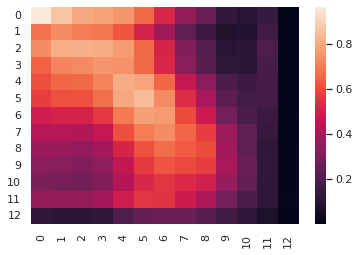

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# create some random data; replace that by your actual dataset
data = pd.DataFrame(np.array(outer_list), columns=range(13), index = range(13))

# plot heatmap
ax = sns.heatmap(data.T)

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
# plt.savefig('seabornPandas.png', dpi=100)
plt.show()

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

df = px.data.stocks()#.tail(50)
df = df.drop(['date'], axis = 1)
dfc = df.corr()
z = dfc.values.tolist()
z = similarity

# change each element of z to type string for annotations
# z_text = [[str(y) for y in x] for x in z]
z_text = [[str(round(y, 4)) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=list(range(13)),
                                     y=list(range(13)),
                                     annotation_text=z_text, colorscale='agsunset')

# add title
fig.update_layout(title_text='<i><b>CKA Similarity before and after finetuning BERT layers</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="",
                        xref="paper",
                        yref="paper"))

In [1]:
import pickle
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

with open('../data/pickled/bert_sentence_representations_for_vendors.pickle', 'rb') as handle:
    sentence_representation = pickle.load(handle)

In [2]:
vendor_name = list(sentence_representation.keys())

In [94]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sentence_representation['debuyerking'],
    sentence_representation['drunkninja']
).shape

(504, 384)

In [95]:
sentence_representation['debuyerking'].shape, sentence_representation['drunkninja'].shape

(torch.Size([504, 768]), torch.Size([384, 768]))

In [101]:
cosine_similarity(sentence_representation['planet-pluto'],
    sentence_representation['planet-pluto']
).mean()

0.7175923

In [3]:
vendor_dict = {}
pbar = tqdm(total=len(vendor_name))

for vendor1 in vendor_name:
    for vendor2 in vendor_name:
        vendor_dict[(vendor1, vendor2)] = cosine_similarity(
            sentence_representation[vendor1], sentence_representation[vendor2]).mean()
    pbar.update(1)
pbar.close()

100%|██████████| 3605/3605 [5:49:06<00:00,  5.81s/it]  


In [4]:
with open('../data/pickled/cosine_similarity_between_vendors.pickle', 'wb') as handle:
    pickle.dump(vendor_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
x_vendor = [vendor1 for (vendor1,vendor2) in vendor_dict.keys()]
y_vendor = [vendor2 for (vendor1,vendor2) in vendor_dict.keys()]
cosine_similarity = [value for value in vendor_dict.values()]

In [7]:
len(x_vendor), len(y_vendor), len(cosine_similarity)

(12996025, 12996025, 12996025)

In [8]:
import pandas as pd
df = pd.DataFrame(data={'vendors':x_vendor, 'closest vendors':y_vendor, 'similarity':cosine_similarity})

In [ ]:
compression_opts = dict(method='zip', archive_name='../data/vendor_similarity.csv')  
df.to_csv('../data/vendor_similarity.zip', index=False, compression=compression_opts) 

# Loading the saved dataframe

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/vendor_similarity.csv')

In [3]:
vendor_list, closest_vendor_list, similarity_list = ([] for i in range(3))


,vendors,closest vendors,similarity
0,debuyerking,debuyerking,0.804351
1,debuyerking,drunkninja,0.315869
2,debuyerking,pckabml,0.151526
3,debuyerking,amphetamine,0.048410
4,debuyerking,uridol,-0.014853
...,...,...,...
12996020,hoggs,scooterfan,0.149337
12996021,hoggs,rainbow snail,0.078590
12996022,hoggs,theauconnection,0.182386
12996023,hoggs,thedman62,-0.006573
